In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd


## Parameterize the track

In [2]:
# 1. set file path
file_path = "Nuerburgring.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

       # x_m        y_m  w_tr_right_m  w_tr_left_m
0   1.242679  -1.293111         7.288        7.487
1  -2.368512  -4.753954         7.307        7.469
2  -5.979276  -8.215237         7.342        7.426
3  -9.589590 -11.676983         7.377        7.383
4 -13.199433 -15.139219         7.411        7.340


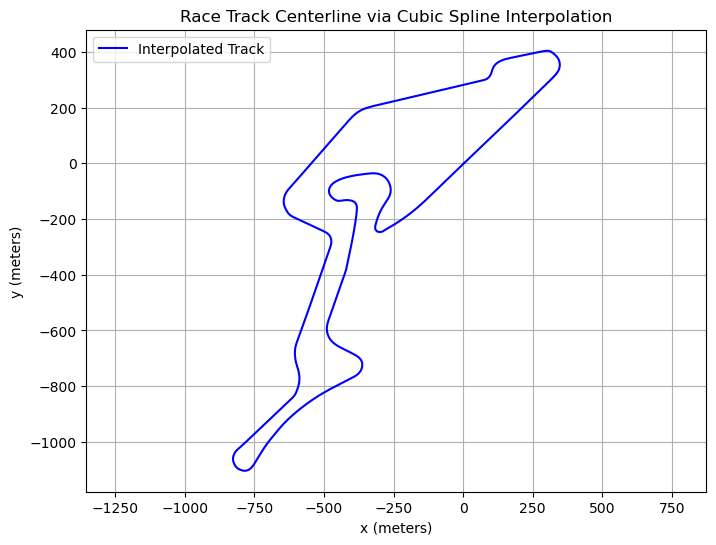

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

## Find optimal reference path

Using $(s, r)$ to represent the vehicle's position, where $s$ is the projection on the centre line and $r$ is the lateral distance relative to it. Let $\kappa(t)$ be the curvature of the path at time $t$, $T$ be the predictive time scale, $t_i$ be the initial time, $\psi(t)$ be the path angle at time $t$, and $\psi_{\text{ref}}(t)$ be the centre line's angle at the vehicle's position at time $t$.

---

**Side notes – coordinate transform:**

$$
\kappa_{\text{ref}}(s) = \frac{x'_{\text{ref}}(s) y''_{\text{ref}}(s) - y'_{\text{ref}}(s) x''_{\text{ref}}(s)}{(x'_{\text{ref}}(s)^2 + y'_{\text{ref}}(s)^2)^{3/2}}
$$

$$
x(t) = x_{\text{ref}}(S(t)) - r(t) \cdot \sin(\psi_{\text{ref}}(S(t)))
$$

$$
y(t) = y_{\text{ref}}(S(t)) + r(t) \cdot \cos(\psi_{\text{ref}}(S(t)))
$$

---

According to Mathias, one possible formulation of this problem is the following:

### Objective

Minimize the objective function:

$$
-s(t_i + T)
$$

### Subject to:

- **System dynamics:**
$$
\dot{x} = f(x,u)
$$
where
$$
x(t) =
\begin{bmatrix}
s(t) \\
n(t) \\
\xi(t) \\
\beta(t) \\
\dot{\Psi}(t) \\
v(t)
\end{bmatrix} \textit{is the state variable},
$$

$$
u(t) = 
\begin{bmatrix}
\delta_f(t)\\
F_{dr}(t)
\end{bmatrix} \textit{is the control variable},
$$

$$
f(x,u) =
\begin{bmatrix}
\frac{v \cdot \cos(\xi + \beta)}{1 - n \kappa(s(t))} \\
v \cdot \sin(\xi + \beta) \\[1.2ex]
\dot{\Psi} - \kappa \cdot \frac{v \cos(\xi + \beta)}{1 - n \kappa(s(t))} \\[1.2ex]
\left( -\dot{\Psi} + \frac{1}{m \cdot v} \left[ 
(F_{Yfl} + F_{Yfr}) \cos(\delta_f - \beta) +
(F_{Yrl} + F_{Yrr}) \cos(\delta_r - \beta) - F_{dr} \sin(\beta)
\right] \right) \\[2ex]
\frac{1}{J_{zz}} \left[
F_{Yfl} \left( l_f \cos \delta_f - \frac{w_f}{2} \sin \delta_f \right) +
F_{Yfr} \left( l_f \cos \delta_f + \frac{w_f}{2} \sin \delta_f \right) + 
F_{Yrl} \left( -l_r \cos \delta_r - \frac{w_r}{2} \sin \delta_r \right) +
F_{Yrr} \left( -l_r \cos \delta_r + \frac{w_r}{2} \sin \delta_r \right)
\right] \\[2ex]
\frac{1}{m} \left[
(F_{Yfl} + F_{Yfr}) \sin(\beta - \delta_f) +
(F_{Yrl} + F_{Yrr}) \sin(\beta - \delta_r) +
F_{dr} \cos \beta - F_{roll} - [F_{aero}]\textit{(omit this term for now)}
\right]
\end{bmatrix},
$$


$$
F_{\text{roll}} = \mu_{roll} \cdot m \cdot g
\\
[F_{\text{aero}} = \frac{1}{2} \cdot \rho \cdot C_d \cdot A_f \cdot v^2] \textit{(omit this term for now)}
\\
F_Z = F_{Zfl} = F_{Zfr} = F_{Zrl} = F_{Zrr} = \frac{1}{4} m \cdot g
\\
\alpha_{fl} = \delta_f - \arctan\left( \frac{v \cdot \sin \beta + l_f \cdot \dot{\Psi}}{v \cdot \cos \beta - \frac{w_f}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{fr} = \delta_f - \arctan\left( \frac{v \cdot \sin \beta + l_f \cdot \dot{\Psi}}{v \cdot \cos \beta + \frac{w_f}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{rl} = \delta_r - \arctan\left( \frac{v \cdot \sin \beta - l_r \cdot \dot{\Psi}}{v \cdot \cos \beta -\frac{w_r}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{rr} = \delta_r - \arctan\left( \frac{v \cdot \sin \beta - l_r \cdot \dot{\Psi}}{v \cdot \cos \beta + \frac{w_r}{2} \cdot \dot{\Psi}} \right)
$$

$$
F_{Yfl} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{fl}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{fl}))\right)
\\
F_{Yfr} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{fr}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{fr}))\right)
\\
F_{Yrl} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{rl}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{rl}))\right)
\\
F_{Yrr} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{rr}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{rr}))\right)
$$



- **Initial conditions:**

$$
x(0)=x_0
$$

- **State constraints:**

$$
n(t) \in [n_{\min}(s(t)),\, n_{\max}(s(t))]
$$

- **Control constraints:**

$$
F_{dr}\leq F_{MAX}
\\
|\delta_f| \leq \delta_{MAX}
\\
\left( \frac{F_{Yfl}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot F_{\text{roll}}}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yfr}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot F_{\text{roll}}}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yrl}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot \left( F_{dr}+F_{\text{roll}}\right)}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yrr}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot \left( F_{dr}+F_{\text{roll}}\right)}{\mu F_Z} \right)^2 \leq 1
$$


In [4]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [18]:
##==car parameter==
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -2000
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2

In [26]:
def setup_mpc_solver(N, T, initial_state, warm_start=None):
    ##==car parameter==
    m = 1500
    g = 9.81
    mu_roll = 0.008
    mu = 1
    F_MAX = 2000
    F_MIN = -2000
    delta_MAX = np.pi / 6
    J_zz = 3000
    l_f = 1.5
    l_r = 1.5
    w_f = 1.2
    w_r = 1.2
    
    dt = T / N
    opti = ca.Opti()

    # Variables
    s = opti.variable(N+1)
    n = opti.variable(N+1)
    xi = opti.variable(N+1)
    beta = opti.variable(N+1)
    psi_dot = opti.variable(N+1)
    v = opti.variable(N+1)
    delta_f = opti.variable(N)
    F_dr = opti.variable(N)

    F_roll = mu_roll * m * g
    F_Z = m * g / 4

    for k in range(N):
        kappa = kappa_ref(s[k])
        alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
        alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
        alpha_rl = - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
        alpha_rr = - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])

        F_y = lambda alpha: ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))
        FYfl = F_y(alpha_fl)
        FYfr = F_y(alpha_fr)
        FYrl = F_y(alpha_rl)
        FYrr = F_y(alpha_rr)
        # system dynamics
        ds = v[k]*ca.cos(xi[k] + beta[k]) / (1 - n[k]*kappa)
        dn = v[k]*ca.sin(xi[k] + beta[k])
        dxi = psi_dot[k] - kappa * ds
        dbeta = (-psi_dot[k] + 1/(m*v[k]) * (
            (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
            (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
        ))
        dpsi_dot = 1/J_zz * (
            FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
            FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
            FYrl*(-l_r) +
            FYrr*(-l_r)
        )
        dv = 1/m * (
            (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
            (FYrl + FYrr)*ca.sin(beta[k]) +
            F_dr[k]*ca.cos(beta[k]) - F_roll
        )

        # Integrate
        opti.subject_to(s[k+1] == s[k] + dt*ds)
        opti.subject_to(n[k+1] == n[k] + dt*dn)
        opti.subject_to(xi[k+1] == xi[k] + dt*dxi)
        opti.subject_to(beta[k+1] == beta[k] + dt*dbeta)
        opti.subject_to(psi_dot[k+1] == psi_dot[k] + dt*dpsi_dot)
        opti.subject_to(v[k+1] == v[k] + dt*dv)

        # Control and friction constraints
        opti.subject_to(F_dr[k] <= F_MAX)
        opti.subject_to(F_dr[k] >= F_MIN)
        opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

        opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
        opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
        opti.subject_to((FYrl/(mu*F_Z))**2 + ((F_dr[k]+0.25*F_roll)/(mu*F_Z))**2 <= 1)
        opti.subject_to((FYrr/(mu*F_Z))**2 + ((F_dr[k]+0.25*F_roll)/(mu*F_Z))**2 <= 1)

    # Initial state constraint
    opti.subject_to(s[0] == initial_state[0])
    opti.subject_to(n[0] == initial_state[1])
    opti.subject_to(xi[0] == initial_state[2])
    opti.subject_to(beta[0] == initial_state[3])
    opti.subject_to(psi_dot[0] == initial_state[4])
    opti.subject_to(v[0] == initial_state[5])

    for k in range(N+1):
        opti.subject_to(v[k] >= 0.5)
        nmin, nmax = -10, 10
        opti.subject_to(n[k] >= nmin)
        opti.subject_to(n[k] <= nmax)

    opti.minimize(-s[N])  # Maximize forward progress

    # Warm-start if provided
    if warm_start:
        opti.set_initial(s, warm_start["s"])
        opti.set_initial(n, warm_start["n"])
        opti.set_initial(xi, warm_start["xi"])
        opti.set_initial(beta, warm_start["beta"])
        opti.set_initial(psi_dot, warm_start["psi_dot"])
        opti.set_initial(v, warm_start["v"])
        opti.set_initial(delta_f, warm_start["delta_f"])
        opti.set_initial(F_dr, warm_start["F_dr"])
    else:
        opti.set_initial(s, 0)#np.linspace(initial_state[0], initial_state[0]+50, N+1))
        opti.set_initial(n, 0)
        opti.set_initial(xi, 0)
        opti.set_initial(beta, 0)
        opti.set_initial(psi_dot, 0)
        opti.set_initial(v, 0.5)
        opti.set_initial(delta_f, 0)
        opti.set_initial(F_dr, 0)

    opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 50000,
        "constr_viol_tol": 1e-6,  # 限制最大允许违反程度
        "compl_inf_tol": 1e-6,    # 对互补条件的容忍度
        "acceptable_constr_viol_tol": 1e-5
    })

    return opti, s, n, xi, beta, psi_dot, v, delta_f, F_dr




In [28]:
##==car parameter==
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -2000
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2

state = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5])
sim_steps = 100
horizon = 50
T = 5
dt = T / horizon

state_log = [state.copy()]
control_log = []
prev_solution = None

for step in range(sim_steps):
    print(f"MPC Step {step}")
    try:
        opti, s_var, n_var, xi_var, beta_var, psi_dot_var, v_var, delta_f_var, F_dr_var = setup_mpc_solver(
            horizon, T, state, warm_start=prev_solution
        )
        sol = opti.solve()
    except RuntimeError as e:
        print("Solver failed.")
        print(e)
        break

    # Extract first control
    delta_cmd = sol.value(delta_f_var[0])
    F_cmd = sol.value(F_dr_var[0])
    control_log.append([delta_cmd, F_cmd])

    # Extract full trajectory for warm start
    prev_solution = {
        "s": np.hstack([sol.value(s_var)[1:], sol.value(s_var)[-1]]),
        "n": np.hstack([sol.value(n_var)[1:], sol.value(n_var)[-1]]),
        "xi": np.hstack([sol.value(xi_var)[1:], sol.value(xi_var)[-1]]),
        "beta": np.hstack([sol.value(beta_var)[1:], sol.value(beta_var)[-1]]),
        "psi_dot": np.hstack([sol.value(psi_dot_var)[1:], sol.value(psi_dot_var)[-1]]),
        "v": np.hstack([sol.value(v_var)[1:], sol.value(v_var)[-1]]),
        "delta_f": np.hstack([sol.value(delta_f_var)[1:], sol.value(delta_f_var)[-1]]),
        "F_dr": np.hstack([sol.value(F_dr_var)[1:], sol.value(F_dr_var)[-1]])
    }

    # Apply first control to simulate one step
    alpha_fl = delta_cmd - np.arctan2(state[5]*np.sin(state[3]) + l_f*state[4], state[5]*np.cos(state[3]) - w_f/2*state[4])
    alpha_fr = delta_cmd - np.arctan2(state[5]*np.sin(state[3]) + l_f*state[4], state[5]*np.cos(state[3]) + w_f/2*state[4])
    alpha_rl = - np.arctan2(state[5]*np.sin(state[3]) - l_r*state[4], state[5]*np.cos(state[3]) - w_r/2*state[4])
    alpha_rr = - np.arctan2(state[5]*np.sin(state[3]) - l_r*state[4], state[5]*np.cos(state[3]) + w_r/2*state[4])
    F_y_np = lambda a: np.sin(1.9 * np.arctan(10 * np.sin(a))) + 0.97 * np.sin(np.arctan(10 * np.sin(a)))
    FYfl = F_y_np(alpha_fl)
    FYfr = F_y_np(alpha_fr)
    FYrl = F_y_np(alpha_rl)
    FYrr = F_y_np(alpha_rr)
    F_roll_val = mu_roll * m * g
    kappa = kappa_ref(state[0])

    ds = state[5]*np.cos(state[2] + state[3]) / (1 - state[1]*kappa)
    dn = state[5]*np.sin(state[2] + state[3])
    dxi = state[4] - kappa * ds
    dbeta = (-state[4] + 1/(m*state[5]) * (
        (FYfl + FYfr)*np.cos(delta_cmd - state[3]) +
        (FYrl + FYrr)*np.cos(-state[3]) - F_cmd*np.sin(state[3])
    ))
    dpsi_dot = 1/J_zz * (
        FYfl*(l_f*np.cos(delta_cmd) - w_f/2*np.sin(delta_cmd)) +
        FYfr*(l_f*np.cos(delta_cmd) + w_f/2*np.sin(delta_cmd)) +
        FYrl*(-l_r) + FYrr*(-l_r)
    )
    dv = 1/m * (
        (FYfl + FYfr)*np.sin(state[3] - delta_cmd) +
        (FYrl + FYrr)*np.sin(state[3]) +
        F_cmd*np.cos(state[3]) - F_roll_val
    )
    print(type(ds))
    print(type(dn))
    print(type(dxi))
    print(type(dbeta))
    print(type(dpsi_dot))
    print(type(dv))
    state = state + dt * np.array([float(ds), dn, float(dxi), dbeta, dpsi_dot, dv])
    state_log.append(state.copy())


MPC Step 0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  85.00us (594.41ns)  81.29us (568.48ns)       143
       nlp_g  |   4.71ms ( 32.91us)   4.67ms ( 32.68us)       143
  nlp_grad_f  | 132.00us (  1.12us) 131.55us (  1.11us)       118
  nlp_hess_l  |  32.46ms (282.30us)  32.51ms (282.73us)       115
   nlp_jac_g  |  17.94ms (150.75us)  18.00ms (151.23us)       119
       total  | 342.63ms (342.63ms) 342.63ms (342.63ms)         1
<class 'casadi.casadi.DM'>
<class 'numpy.float64'>
<class 'casadi.casadi.DM'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
MPC Step 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 248.39ms (650.10ns) 218.71ms (572.44ns)    382073
       nlp_g  |  12.25 s ( 32.04us)  12.19 s ( 31.88us)    382274
  nlp_grad_f  |   1.82ms (  1.26us)   1.63ms (  1.12us)      1450
  nlp_hess_l  |  13.98 s (279.55us)  14.00 s (280.00us)     49991
   nlp_jac_g  |   7.40 s (147.37us) 

In [25]:
state_log

[array([0. , 0. , 0. , 0. , 0. , 0.5]),
 array([ 2.50000000e-02,  0.00000000e+00, -5.80616081e-07, -8.17985341e-05,
        -3.06744503e-05,  5.62715916e-01])]

In [22]:
opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/1609 ------ 
0 <= 1.77436e-12 <= 0 (viol 1.77436e-12)
Opti constraint of shape 1x1, called from /var/folders/l_/gv8mx2r57n94pltqp7kwdz1r0000gn/T/ipykernel_15254/900175380.py:65 in setup_mpc_solver
------- i = 1/1609 ------ 
0 <= -1.43483e-11 <= 0 (viol 1.43483e-11)
Opti constraint of shape 1x1, called from /var/folders/l_/gv8mx2r57n94pltqp7kwdz1r0000gn/T/ipykernel_15254/900175380.py:66 in setup_mpc_solver
------- i = 2/1609 ------ 
0 <= -2.2464e-10 <= 0 (viol 2.2464e-10)
Opti constraint of shape 1x1, called from /var/folders/l_/gv8mx2r57n94pltqp7kwdz1r0000gn/T/ipykernel_15254/900175380.py:67 in setup_mpc_solver
------- i = 3/1609 ------ 
0 <= -8.82605e-11 <= 0 (viol 8.82605e-11)
Opti constraint of shape 1x1, called from /var/folders/l_/gv8mx2r57n94pltqp7kwdz1r0000gn/T/ipykernel_15254/900175380.py:68 in setup_mpc_solver
------- i = 4/1609 ------ 
0 <= -1.96017e-10 <= 0 (viol 1.96017e-10)
Opti constraint of shape 1x1, c